In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
# !pip install tensorflow-addons
# !pip install tensorflow
# !pip install tensorflow_hub

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
from IPython.display import display, Image

In [22]:
# Import TF 2.x
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

## Preprocess Data
### read from csv -> filename and labels
* a list of all filename
* a list of unique breed name


### split into train/valid/test set

In [23]:
labels_csv = pd.read_csv("labels.csv")
labels_csv.describe()
# labels_csv.head()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [24]:
filenames = []
for filename in labels_csv.id:
  filenames.append("train/" + filename + ".jpg")

# filenames[:10]

In [25]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("train")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files")

Filenames match actual amount of files!


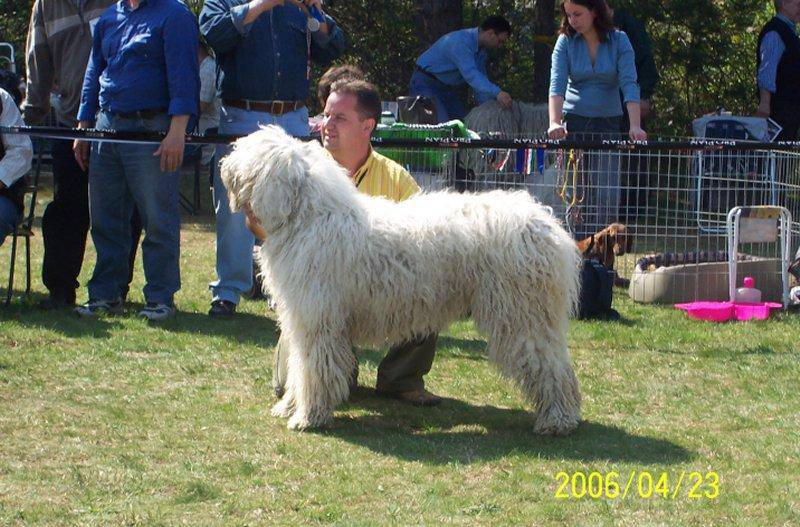

In [26]:
Image(filenames[101])

In [77]:
labels = labels_csv["breed"].to_numpy()
# check if every image has a label
if len(labels) == len(filenames):
   print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames")
unique_labels = np.unique(labels)
unique_labels

Number of labels matches number of filenames!


array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

Turn into categorical array (one-hot vector)

In [28]:
one_hot_labels = [(label == np.array(unique_labels)).astype(int) for label in labels]

Split into train/valid

In [29]:
NUM_IMAGES = 10000 #@param {type:"slider", min:1000, max:10222, step:100}
NUM_IMAGES

10000

In [30]:
X = filenames
y = one_hot_labels
# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

## Preprocessing images (turning images into Tensors)

In [31]:
# Define parameters here
IMG_SIZE = 224
BATCH_SIZE = 32
data_augmentation = True

In [32]:
def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  if not data_augmentation:
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  else:
    # Data augmentation
    image = tf.image.random_flip_left_right(image) # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2) # Random contrast
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2) # Random saturation

    # Rotate the image by a random angle between -10 and +10 degrees
    random_angle = tf.random.uniform((), minval=-10, maxval=10, dtype=tf.float32) * (3.14159265 / 180) # Convert degrees to radians
    image = tfa.image.rotate(image, random_angle, interpolation='BILINEAR')

    # Random zoom
    scales = list(np.arange(1.0, 1.2, 0.01))
    scale = np.random.choice(scales)
    image = tf.image.resize(image, size=[int(IMG_SIZE * scale), int(IMG_SIZE * scale)])
    image = tf.image.resize_with_crop_or_pad(image, target_height=IMG_SIZE, target_width=IMG_SIZE)

  return image

def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label
# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [33]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [34]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_labels[one_hot_labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

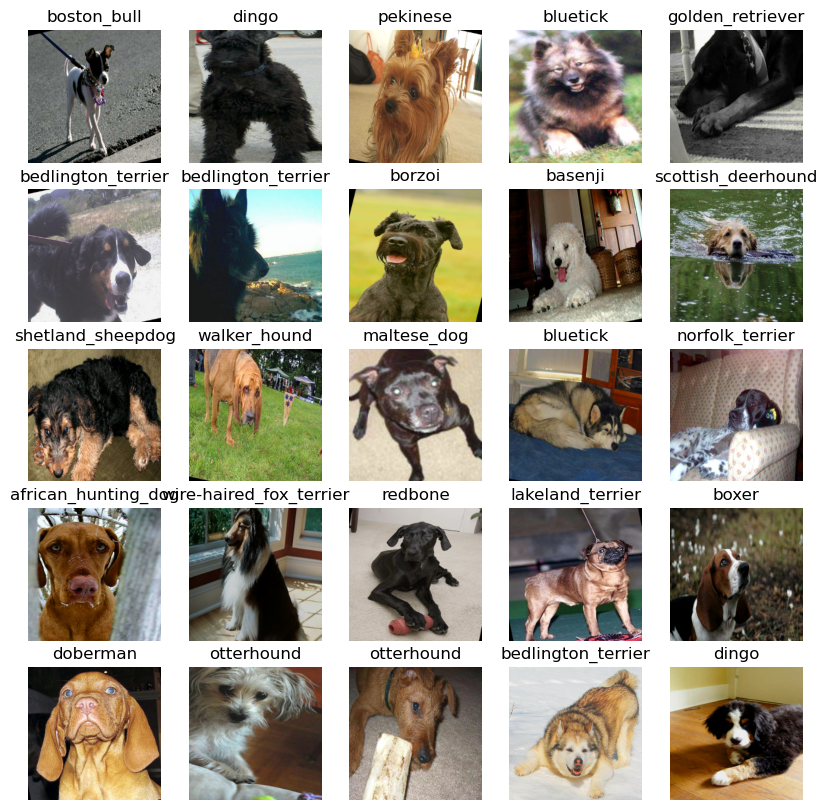

In [35]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [36]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_labels) # number of unique labels

# Setup model URL from TensorFlow Hub
# MODEL_URL = "https://tfhub.dev/tensorflow/efficientnet/b0/classification/1" # b0 does not work well
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE[1:],
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [37]:
from tensorflow.keras import regularizers
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)
  # Setup the model layers

  # base_model = hub.KerasLayer(MODEL_URL, trainable=False)
  # for layer in base_model._layers[-10:]:
  #   layer.trainable = True

  model = tf.keras.Sequential([
    # base_model,
    hub.KerasLayer(MODEL_URL, trainable=False), # Layer 1 (input layer)
    # Add a Dense layer with both L1 and L2 regularization
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    tf.keras.layers.Dropout(rate = 0.1),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), 
      optimizer=tf.keras.optimizers.Adam(), 
      metrics=["accuracy"] 
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model


In [38]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 128)               128256    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               15480     
                                                                 
Total params: 5,576,449
Trainable params: 143,736
Non-trainable params: 5,432,713
_________________________________________________________________


In [39]:
%load_ext tensorboard
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Doggy_data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3) # stops after 3 rounds of no improvements
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [41]:
NUM_EPOCHS = 50 #@param {type:"slider", min:10, max:100, step:10}

In [42]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()
  model.summary()
  # Create new TensorBoard session everytime we train a model
  # tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[early_stopping, model_checkpoint])
  
  
  return model

In [43]:
# model = train_model()


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 128)               128256    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               15480     
                                                                 
Total params: 5,576,449
Trainable params: 143,736
Non-trainable params: 5,432,713
_________________________________________________________________


In [45]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join(
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = "./" + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3) # stops after 3 rounds of no improvements
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='accuracy', save_best_only=True)

In [47]:
full_data = create_data_batches(X, y)

Creating training data batches...


In [48]:
# full_model = create_model()
# full_model.fit(x=full_data,
#             epochs=NUM_EPOCHS,
#             callbacks=[early_stopping, model_checkpoint])

In [49]:
# full_model.save("./full_model.h5")

NameError: name 'full_model' is not defined

In [50]:
full_model = load_model("./full_model.h5")

Loading saved model from: ./full_model.h5


In [55]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]

In [53]:
custom_path = "own/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [58]:
custom_preds = full_model.predict(custom_data)
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

1/1 [==============================] - 2s 2s/step


['bernese_mountain_dog',
 'toy_poodle',
 'bernese_mountain_dog',
 'golden_retriever',
 'siberian_husky',
 'maltese_dog',
 'pomeranian',
 'samoyed',
 'miniature_schnauzer']

In [59]:
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [76]:
top3 = custom_preds[0].argsort()[-3:][::-1]
print(top3)
for i in range(len(top3)):
    print(unique_labels[top3[i]])

[11 99 33]
bernese_mountain_dog
shetland_sheepdog
collie


ValueError: num must be an integer with 1 <= num <= 8, not 9

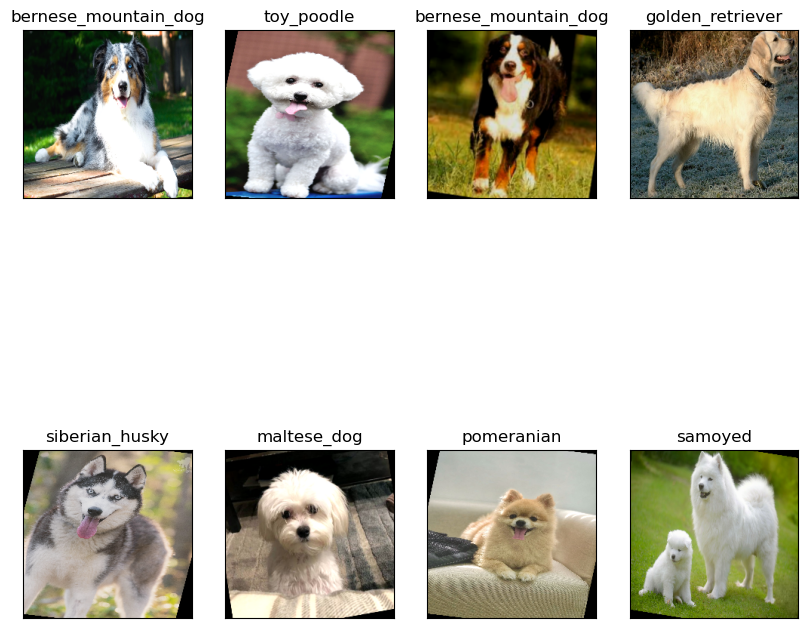

In [66]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(2, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)